<a href="https://colab.research.google.com/github/chaeyh4/MotionSense/blob/main/rotation_transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Author: C. I. Tang
# Based on work of Tang et al.: https://arxiv.org/abs/2011.11542
# Contact: cit27@cl.cam.ac.uk
# License: GNU General Public License v3.0

%load_ext autoreload
%autoreload 2

#Imports

In [2]:
import os
import pickle
import scipy
import datetime
import numpy as np
import tensorflow as tf

seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
# Libraries for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.manifold

sns.set_context('poster')

In [4]:
# Library scripts
import raw_data_processing
import data_pre_processing
import simclr_models
import simclr_utitlities
import transformations

In [5]:
working_directory = 'test_run/'
dataset_save_path = working_directory
if not os.path.exists(working_directory):
    os.mkdir(working_directory)


# Motion Sense Dataset

In this section, the MotionSense dataset will be downloaded and parsed. The results will then be saved in a python pickle file.
(Note: This section only needs to be run once)

Citation:
```
@inproceedings{Malekzadeh:2019:MSD:3302505.3310068,
author = {Malekzadeh, Mohammad and Clegg, Richard G. and Cavallaro, Andrea and Haddadi, Hamed},
title = {Mobile Sensor Data Anonymization},
booktitle = {Proceedings of the International Conference on Internet of Things Design and Implementation},
series = {IoTDI '19},
year = {2019},
isbn = {978-1-4503-6283-2},
location = {Montreal, Quebec, Canada},
pages = {49--58},
numpages = {10},
url = {http://doi.acm.org/10.1145/3302505.3310068},
doi = {10.1145/3302505.3310068},
acmid = {3310068},
publisher = {ACM},
address = {New York, NY, USA},
keywords = {adversarial training, deep learning, edge computing, sensor data privacy, time series analysis},
} 
```

## Downloading and Unzipping

In [6]:
import requests
import zipfile

In [7]:
dataset_url = 'https://github.com/mmalekzadeh/motion-sense/blob/master/data/B_Accelerometer_data.zip?raw=true'

r = requests.get(dataset_url, allow_redirects=True)
with open(working_directory + 'B_Accelerometer_data.zip', 'wb') as f:
    f.write(r.content)

In [8]:
with zipfile.ZipFile(working_directory + 'B_Accelerometer_data.zip', 'r') as zip_ref:
    zip_ref.extractall(working_directory)

##Data Processing

In [9]:
accelerometer_data_folder_path = working_directory + 'B_Accelerometer_data/'
user_datasets = raw_data_processing.process_motion_sense_accelerometer_files(accelerometer_data_folder_path)

test_run/B_Accelerometer_data/dws_1
test_run/B_Accelerometer_data/dws_11
test_run/B_Accelerometer_data/dws_2
test_run/B_Accelerometer_data/jog_16
test_run/B_Accelerometer_data/jog_9
test_run/B_Accelerometer_data/sit_13
test_run/B_Accelerometer_data/sit_5
test_run/B_Accelerometer_data/std_14
test_run/B_Accelerometer_data/std_6
test_run/B_Accelerometer_data/ups_12
test_run/B_Accelerometer_data/ups_3
test_run/B_Accelerometer_data/ups_4
test_run/B_Accelerometer_data/wlk_15
test_run/B_Accelerometer_data/wlk_7
test_run/B_Accelerometer_data/wlk_8


In [10]:
with open(working_directory + 'motion_sense_user_split.pkl', 'wb') as f:
    pickle.dump({
        'user_split': user_datasets,
    }, f)

#Preprocessing

In [11]:
# Parameters
window_size = 400
input_shape = (window_size, 3)

# Dataset Metadata 
transformation_multiple = 1
dataset_name = 'motion_sense.pkl'
dataset_name_user_split = 'motion_sense_user_split.pkl'

label_list = ['null', 'sit', 'std', 'wlk', 'ups', 'dws', 'jog']
label_list_full_name = ['null', 'sitting', 'standing', 'walking', 'walking upstairs', 'walking downstairs', 'jogging']
has_null_class = True

label_map = dict([(l, i) for i, l in enumerate(label_list)])

output_shape = len(label_list)

model_save_name = f"motionsense_acc"

sampling_rate = 50.0
unit_conversion = scipy.constants.g

# a fixed user-split
test_users_fixed = [1, 14, 19, 23, 6]
def get_fixed_split_users(har_users):
    # test_users = har_users[0::5]
    test_users = test_users_fixed
    train_users = [u for u in har_users if u not in test_users]
    return (train_users, test_users)

In [12]:
with open(dataset_save_path + dataset_name_user_split, 'rb') as f:
    dataset_dict = pickle.load(f)
    user_datasets = dataset_dict['user_split']

In [13]:
har_users = list(user_datasets.keys())
train_users, test_users = get_fixed_split_users(har_users)
print(f'Testing: {test_users}, Training: {train_users}')

Testing: [1, 14, 19, 23, 6], Training: [10, 11, 12, 13, 15, 16, 17, 18, 2, 20, 21, 22, 24, 3, 4, 5, 7, 8, 9]


In [14]:
np_train, np_val, np_test = data_pre_processing.pre_process_dataset_composite(
    user_datasets=user_datasets, 
    label_map=label_map, 
    output_shape=output_shape, 
    train_users=train_users, 
    test_users=test_users, 
    window_size=window_size, 
    shift=window_size//2, 
    normalise_dataset=True, 
    verbose=1
)



/content/data_pre_processing.py:42: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return scipy.stats.mode(np_array)[0]


Test
(array(['dws', 'jog', 'sit', 'std', 'ups', 'wlk'], dtype='<U3'), array([112, 133, 360, 335, 148, 331]))
(array([1, 2, 3, 4, 5, 6]), array([360, 335, 331, 148, 112, 133]))
-----------------
Train
(array(['dws', 'jog', 'sit', 'std', 'ups', 'wlk'], dtype='<U3'), array([ 449,  480, 1282, 1146,  546, 1308]))
(array([1, 2, 3, 4, 5, 6]), array([1282, 1146, 1308,  546,  449,  480]))
-----------------
Training data shape: (4168, 400, 3)
Validation data shape: (1043, 400, 3)
Testing data shape: (1419, 400, 3)


#Rotation Transform Visualization

##Original Motion Sense Visualization

In [15]:
import pandas as pd

In [16]:
train_df = pd.DataFrame(data = np_train[0][100], columns = ("x","y","z")) #100은 임의의 수

In [17]:
train_label = np_train[1][100] #100은 임의의 수

In [18]:
train_df

,x,y,z
0,-0.544249,1.064233,1.257425
1,0.456367,1.028703,1.404435
2,0.908416,0.613724,0.698360
3,1.183886,0.084260,-0.289003
4,0.681614,-0.099255,-0.158268
...,...,...,...
395,-0.085292,-0.113539,0.574794
396,-0.712835,0.350966,-0.201917
397,-1.034802,0.482345,-0.076921
398,-0.800245,0.196594,0.996517


In [19]:
train_label

array([0., 0., 0., 1., 0., 0., 0.], dtype=float32)

x,y,z축 동시에 시각화

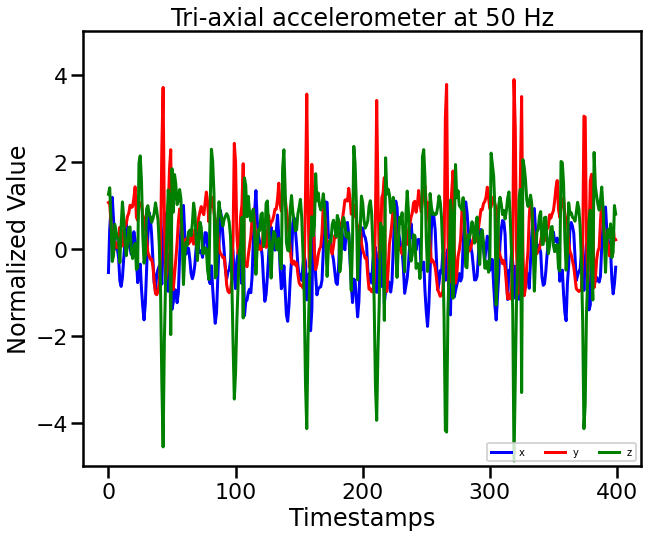

In [20]:
plt.figure(figsize=(10,8))
plt.plot(train_df['x'],label='x', color='b')
plt.plot(train_df['y'],label='y', color='r')
plt.plot(train_df['z'],label='z', color='g')
plt.title('Tri-axial accelerometer at 50 Hz')
plt.xlabel('Timestamps')
plt.ylabel('Normalized Value')
plt.ylim(-5,5)
plt.legend(loc='lower right', ncol=3,fontsize = 10)
plt.show()

x,y,z축 분리해서 시각화 

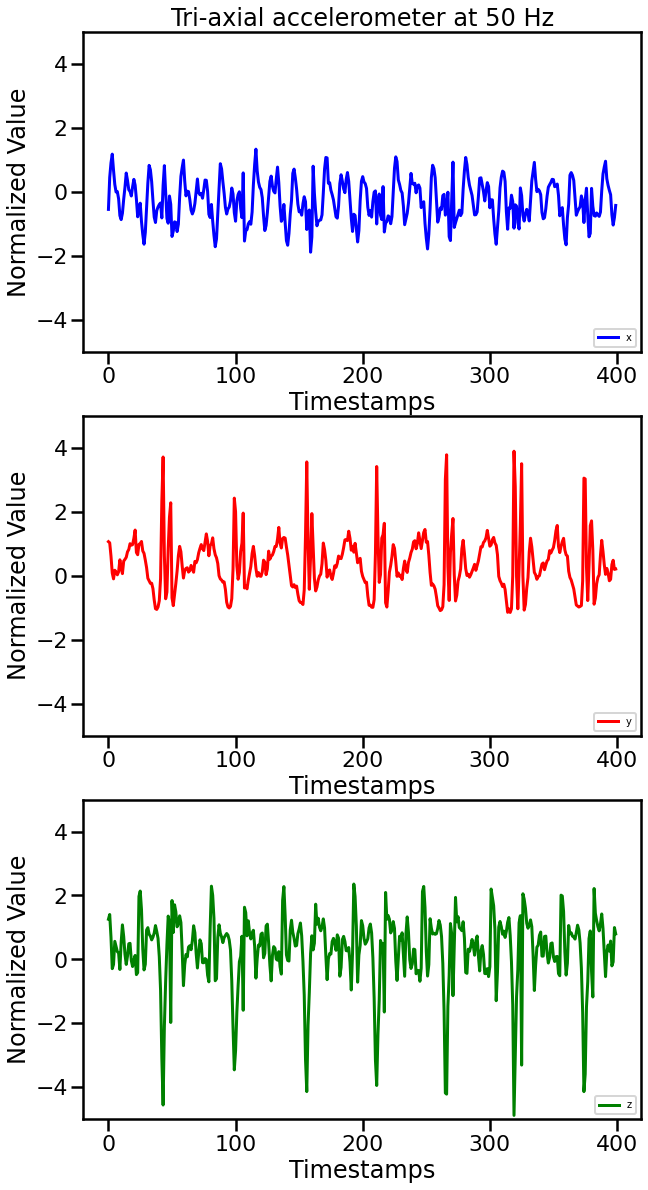

In [21]:
plt.figure(figsize=(10,20))
plt.subplot(3,1,1)
plt.title('Tri-axial accelerometer at 50 Hz')
plt.plot(train_df['x'],label = 'x', color='b')
plt.ylim(-5,5)
plt.xlabel('Timestamps')
plt.ylabel('Normalized Value')
plt.legend(loc='lower right', ncol=3,fontsize = 10)
plt.subplot(3,1,2)
plt.plot(train_df['y'],label = 'y', color='r')
plt.ylim(-5,5)
plt.xlabel('Timestamps')
plt.ylabel('Normalized Value')
plt.legend(loc='lower right', ncol=3,fontsize = 10)
plt.subplot(3,1,3)
plt.plot(train_df['z'],label = 'z', color='g')
plt.ylim(-5,5)
plt.xlabel('Timestamps')
plt.ylabel('Normalized Value')
plt.legend(loc='lower right', ncol=3,fontsize = 10)
plt.show()


##Rotation Transform

### Original Code

In [22]:
def rotation_transform_vectorized(X, angle, axes): 
    """
    Applying a random 3D rotation + 기존 코드에 원하는 angle,axes 값 입력
    """
    #axes = np.random.uniform(low=-1, high=1, size=(X.shape[0], X.shape[2]))
    axes = np.ones((X.shape[0], X.shape[2]))
    axes[:] = axes
    angles =  np.ones(X.shape[0])
    angles[:] = angle
    matrices = axis_angle_to_rotation_matrix_3d_vectorized(axes, angles)

    return np.matmul(X, matrices)

def axis_angle_to_rotation_matrix_3d_vectorized(axes, angles):
    """
    Get the rotational matrix corresponding to a rotation of (angle) radian around the axes

    Reference: the Transforms3d package - transforms3d.axangles.axangle2mat
    Formula: http://en.wikipedia.org/wiki/Rotation_matrix#Axis_and_angle
    """
    axes = axes / np.linalg.norm(axes, ord=2, axis=1, keepdims=True)
    x = axes[:, 0]; y = axes[:, 1]; z = axes[:, 2]
    c = np.cos(angles)
    s = np.sin(angles)
    C = 1 - c

    xs = x*s;   ys = y*s;   zs = z*s
    xC = x*C;   yC = y*C;   zC = z*C
    xyC = x*yC; yzC = y*zC; zxC = z*xC

    m = np.array([
        [ x*xC+c,   xyC-zs,   zxC+ys ],
        [ xyC+zs,   y*yC+c,   yzC-xs ],
        [ zxC-ys,   yzC+xs,   z*zC+c ]])
    matrix_transposed = np.transpose(m, axes=(2,0,1))
    return matrix_transposed

###Rotation Transform Visualization

축 생성

In [23]:
axes = np.random.uniform(low=-1, high=1, size=(1, 3))

In [24]:
axes

array([[ 0.44064899, -0.99977125, -0.39533485]])

데이터프레임 생성

In [29]:
rotated_degree= rotation_transform_vectorized(np_train[0],0,axes)
rotated_degree_df = pd.DataFrame(data = rotated_degree[444], columns = ("x","y","z"))

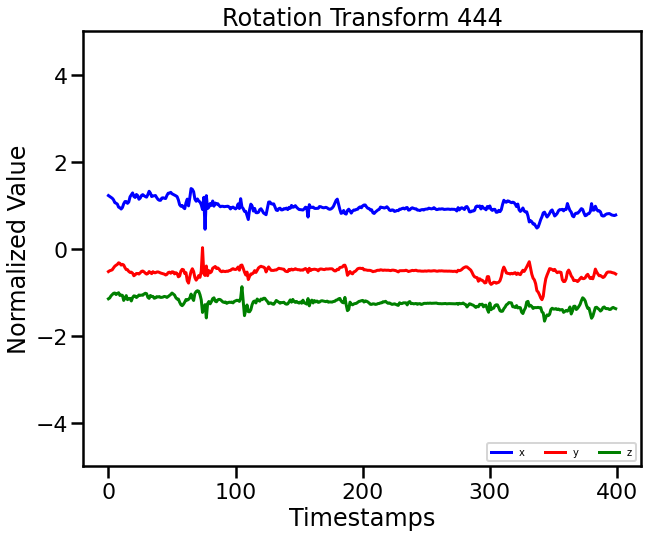

In [30]:
plt.figure(figsize=(10,8))
plt.plot(rotated_degree_df['x'],label='x', color='b')
plt.plot(rotated_degree_df['y'],label='y', color='r')
plt.plot(rotated_degree_df['z'],label='z', color='g')
plt.title('Rotation Transform 444')
plt.xlabel('Timestamps')
plt.ylabel('Normalized Value')
plt.ylim(-5,5)
plt.legend(loc='lower right', ncol=3,fontsize = 10)
plt.show()

In [43]:
rotated_360degree= rotation_transform_vectorized(np_train[0],6.28319,axes)
rotated_360degree_df = pd.DataFrame(data = rotated_degree[444], columns = ("x","y","z"))

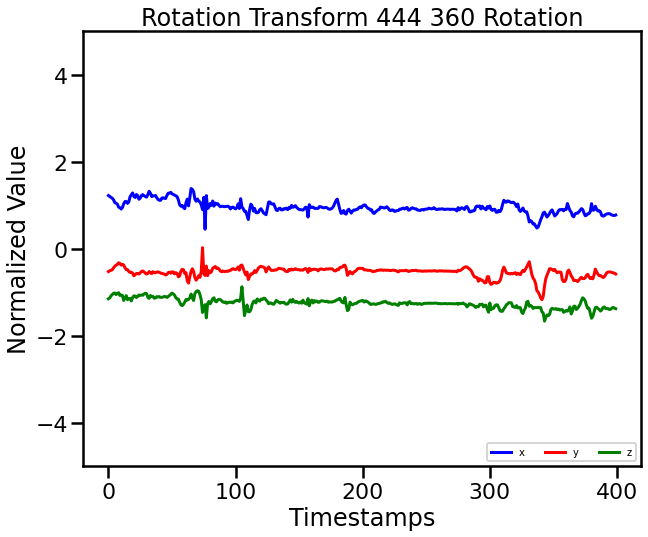

In [45]:
plt.figure(figsize=(10,8))
plt.plot(rotated_360degree_df['x'],label='x', color='b')
plt.plot(rotated_360degree_df['y'],label='y', color='r')
plt.plot(rotated_360degree_df['z'],label='z', color='g')
plt.title('Rotation Transform 444 360 Rotation')
plt.xlabel('Timestamps')
plt.ylabel('Normalized Value')
plt.ylim(-5,5)
plt.legend(loc='lower right', ncol=3,fontsize = 10)
plt.show()

연속으로 회전시킨 센서 시각화

In [34]:
radian = [0,0.523599,1.0472,1.5708,2.0944,2.61799,3.14159,3.66519,4.18879,4.71239,5.23599,5.75959,6.28319]
angle = [0,30,60,90,120,150,180,210,240,270,300,330,360]

In [35]:
dataframe_title = []
for i in range(len(radian)):
  num = str(angle[i])
  title = "rotation_"+num+"_df"
  dataframe_title.append(title)

In [36]:
dataframe_title

['rotation_0_df',
 'rotation_30_df',
 'rotation_60_df',
 'rotation_90_df',
 'rotation_120_df',
 'rotation_150_df',
 'rotation_180_df',
 'rotation_210_df',
 'rotation_240_df',
 'rotation_270_df',
 'rotation_300_df',
 'rotation_330_df',
 'rotation_360_df']

In [38]:
dataframe = []
for i in range(len(radian)):
  dataframe.append(pd.DataFrame(data=rotation_transform_vectorized(np_train[0],radian[i],axes)[444], columns = ("x","y","z"))) #100은 임의의 수

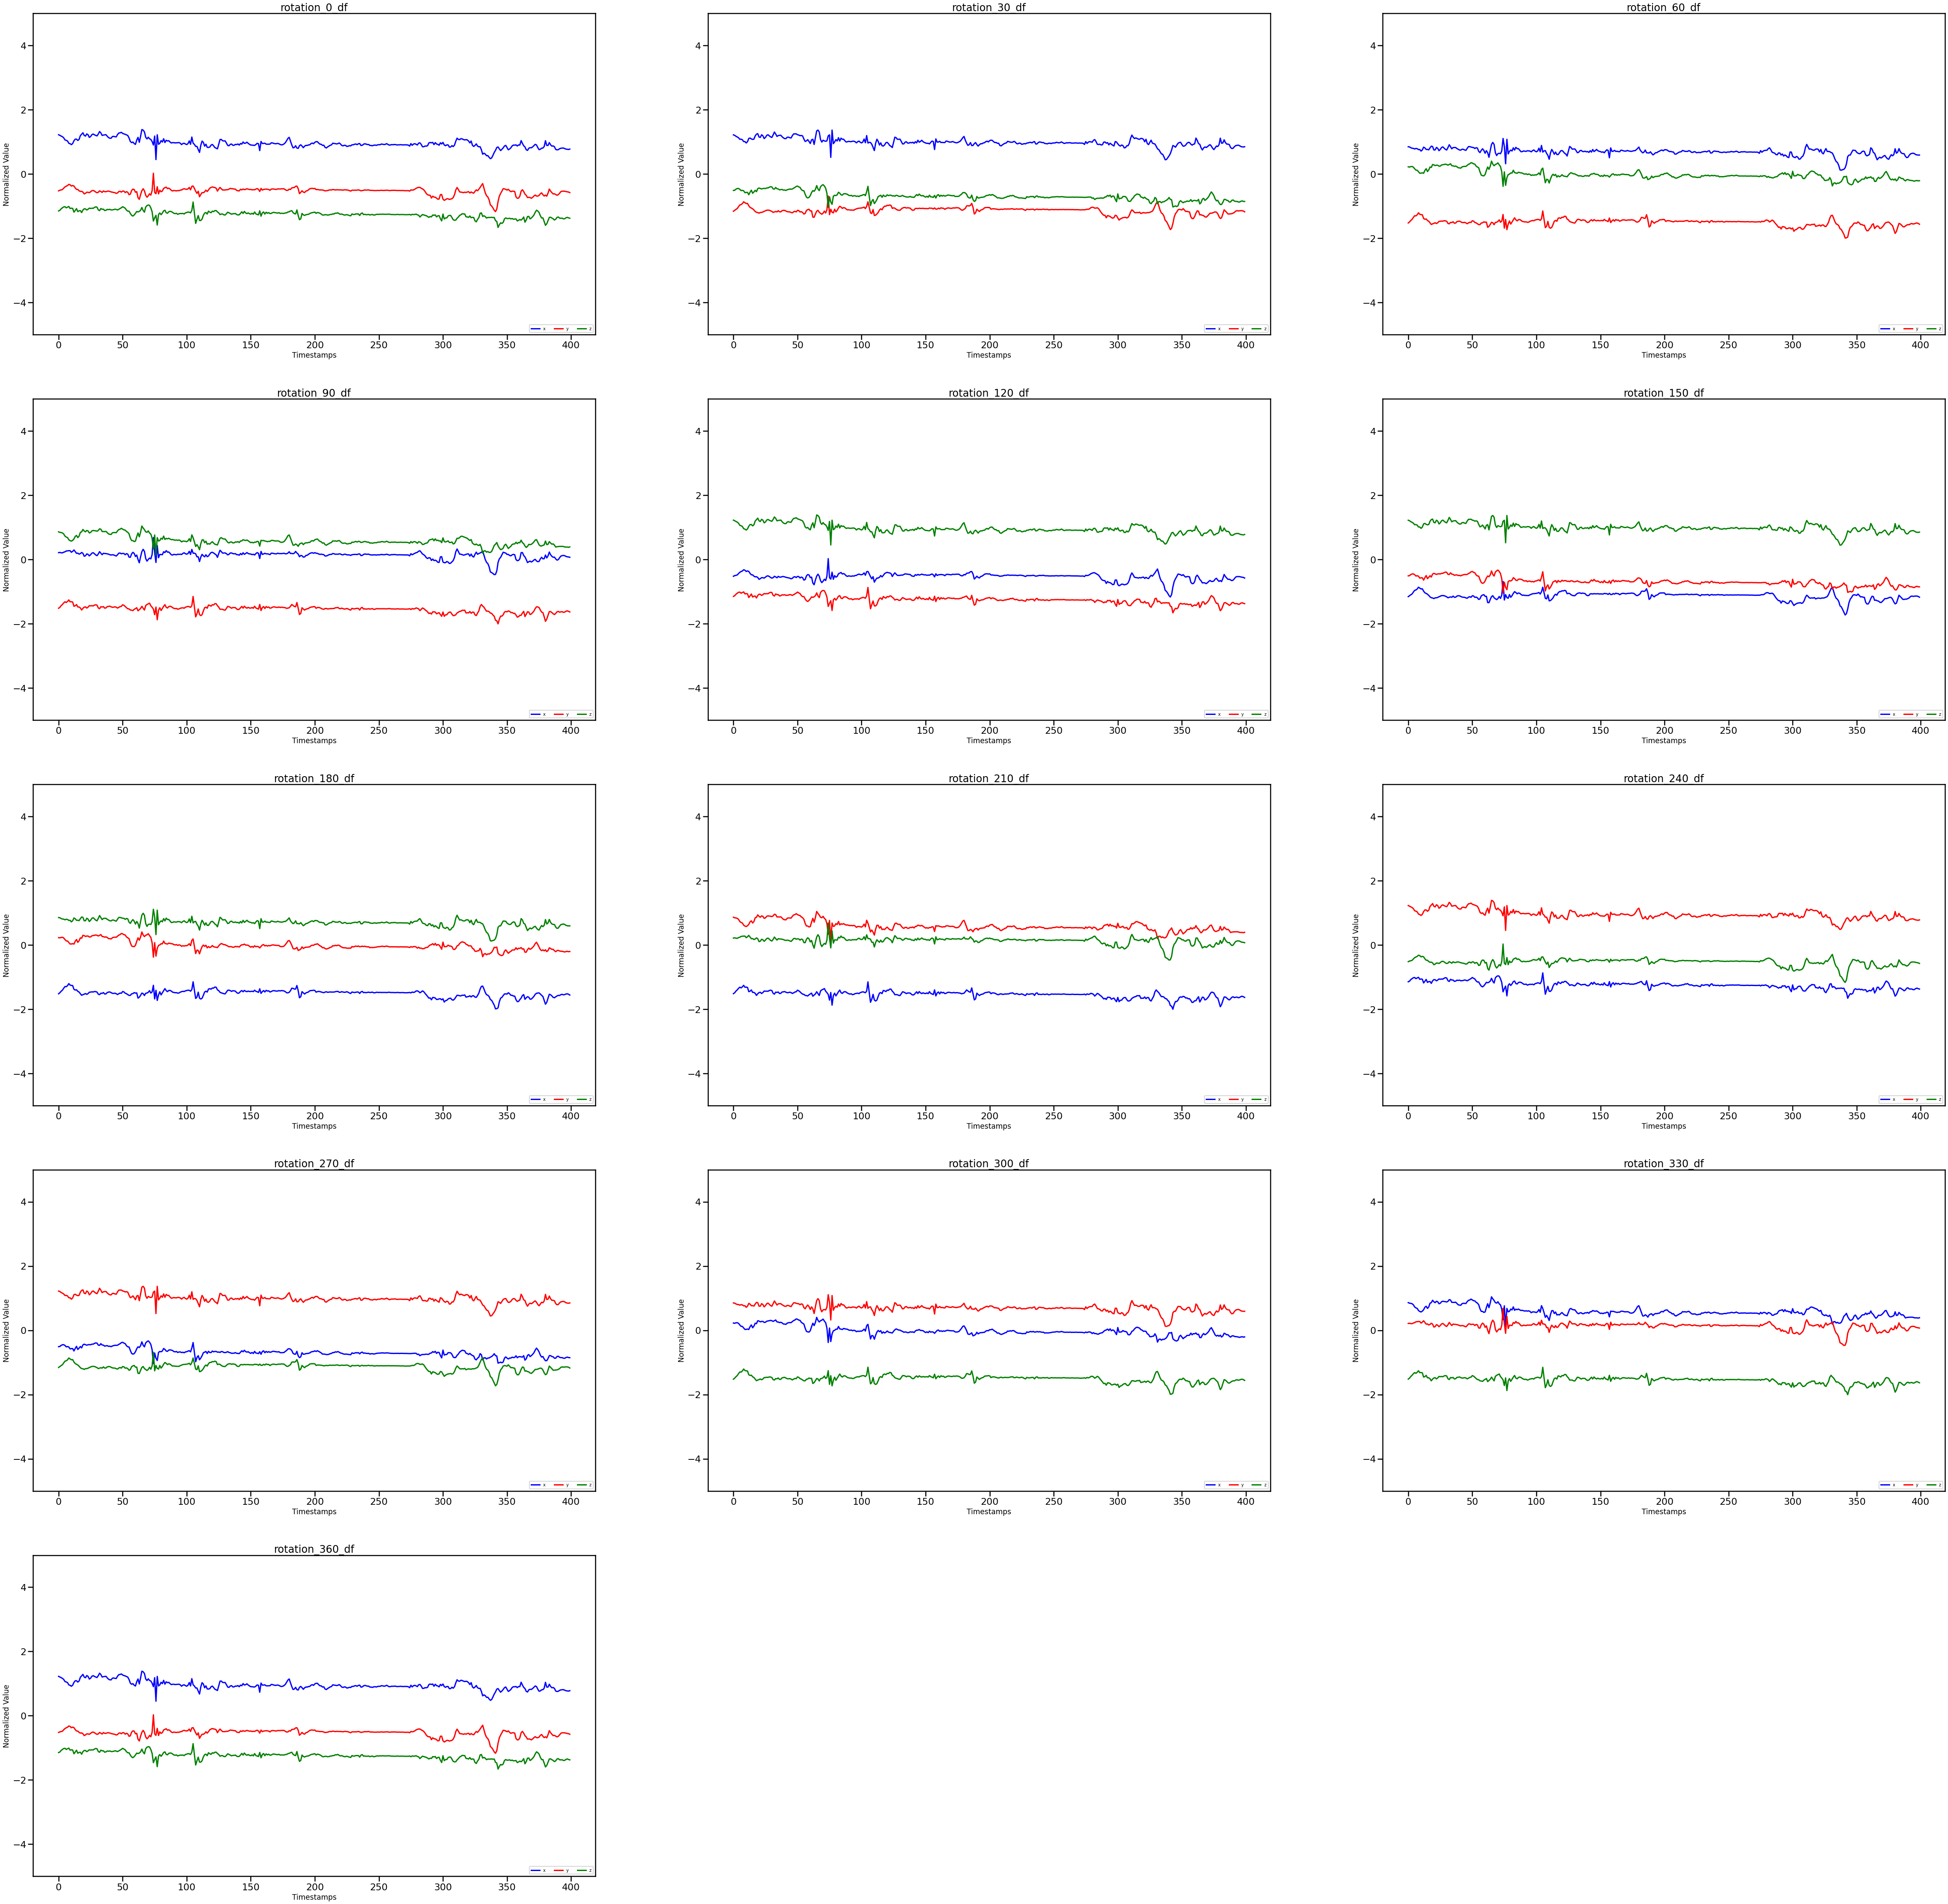

In [39]:
plt.figure(figsize=(80,80))
for i in range(13):
  plt.subplot(5,3,i+1)
  plt.plot(dataframe[i]['x'],label='x', color='b')
  plt.plot(dataframe[i]['y'],label='y', color='r')
  plt.plot(dataframe[i]['z'],label='z', color='g')
  plt.title(dataframe_title[i])
  plt.xlabel('Timestamps',fontsize=17)
  plt.ylabel('Normalized Value',fontsize=17)
  plt.ylim(-5,5)
  plt.legend(loc='lower right', ncol=3,fontsize = 10)
plt.show()